In [1]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [ ]:
!ls 'drive/My Drive/TB_zindi/inputs'

In [ ]:
!pip install pretrainedmodels

In [ ]:
!pip install albumentations

In [ ]:
!pip install torch-lr-finder

In [ ]:
import sys

sys.path.insert(0,'drive/My Drive/TB_zindi/')


import torch
import numpy as np
import random
import pandas as pd
import os
from PIL import Image
import albumentations
from torch.utils.data import Dataset
import torch.nn as nn
import pretrainedmodels
from torch.nn import functional as F
from PIL import ImageFile
from PIL import Image
from sklearn import metrics
from torch.cuda import amp
from source.utils import TB_Dataset, Engine, resnet152, TB_Test_Dataset,TB_Dataset_lr


ImageFile.LOAD_TRUNCATED_IMAGES = True

torch.backends.cudnn.benchmark = False

def set_all_seeds(seed):
  random.seed(seed)
  #os.environ('PYTHONHASHSEED') = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True

set_all_seeds(1234) 


In [ ]:

DEVICE = "cuda"
EPOCHS = 40
batch_size = 32
HEIGHT = 224
WIDTH = 224

def train(fold,save_model=False):
     
    df = pd.read_csv('drive/My Drive/TB_zindi/inputs/TB_stratified_kfold.csv')
    df_train = df[df.kfold!=fold].reset_index(drop=True)

    df_val = df[df.kfold==fold].reset_index(drop=True)

    x_train = df_train.loc[:,["ID"]]
    y_train = df_train.loc[:,["LABEL"]].values

    print(x_train.shape)
    print(y_train.shape)
    x_val = df_val.loc[:,["ID"]]
    y_val = df_val.loc[:,["LABEL"]].values
    
    print(x_val.shape)
    print(y_val.shape)

    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    
    train_aug =albumentations.Compose([  
            albumentations.CLAHE(p=0.001),                                                                                                       
            albumentations.Resize(224,224,always_apply=True),
            albumentations.Normalize(mean,std,max_pixel_value=255.0,always_apply=True),
            albumentations.CenterCrop(height=224,width=224),
            albumentations.ShiftScaleRotate(p=0.001),
            albumentations.HorizontalFlip(p=0.001),
            albumentations.RandomBrightness(p=0.002),
            #albumentations.Cutout(p=0.002),
            

        ])
    
        
    val_aug = albumentations.Compose([
            albumentations.Resize(224,224,always_apply=True),
            albumentations.Normalize(mean,std,max_pixel_value=255.0,always_apply=True),
            albumentations.CenterCrop(224, 224)
        ])
    
    train_data= TB_Dataset('drive/My Drive/TB_zindi/inputs/train_small',x_train, y_train,transform=train_aug)

    train_data_loader = torch.utils.data.DataLoader(train_data,batch_size=32,
    shuffle=True,num_workers=2,pin_memory=True)


    val_data= TB_Dataset('drive/My Drive/TB_zindi/inputs/train_small',x_val, y_val,transform=val_aug)
    val_data_loader = torch.utils.data.DataLoader(val_data,batch_size=batch_size,
    shuffle=False,num_workers=2,pin_memory=True)
    

    model = resnet152(pretrained=True)           
    model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=3,threshold=1e-6,mode='min',verbose=True,factor=0.1)
    
    
    eng = Engine(model,optimizer,DEVICE)
    scaler = amp.GradScaler()
    
    best_loss = np.inf
    early_stoping = 10
    early_stoping_counter = 0

    for epoch in range(EPOCHS):
        train_loss,outputs0,targets0 = eng.train(train_data_loader,scaler)
        train_acc = metrics.roc_auc_score(targets0,outputs0)

        val_loss, outputs,targets = eng.validate(val_data_loader)
        val_acc = metrics.roc_auc_score(targets,outputs)
        scheduler.step(val_loss)

        print(f"fold={fold}",f"epoch={epoch}",f"train_loss={train_loss}",f"train_acc={train_acc}",f"val_loss={val_loss}",f"val_acc={val_acc}")
        
        
        if val_loss<best_loss:
            best_loss = val_loss
            if save_model:
                torch.save(model.state_dict(),f"drive/My Drive/TB_zindi/models/model{fold}.bin")
                print(f"fold={fold}",f"best_val_loss={best_loss}")
                print('model saved!!')
                early_stoping_counter = 0
                
        else: 
            print(early_stoping_counter)
            early_stoping_counter += 1

        if early_stoping_counter > early_stoping:
            break



for i in range(5):
    train(fold=i,save_model=True)
    

In [ ]:
predictions = []
img_ids = []
DEVICE = "cuda"
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
for fold in range(5):

    model = resnet152(pretrained=False)
    model.load_state_dict(torch.load(f"drive/My Drive/TB_zindi/models/model{fold}.bin"))
    model= model.to(DEVICE)
    model.eval()
    test_ids = pd.read_csv('drive/My Drive/TB_zindi/inputs/Test_TB.csv')
    test_ids['ID'] = test_ids['ID'] + '.png'
    test_aug = albumentations.Compose([
            albumentations.Resize(224,224,always_apply=True),
            albumentations.Normalize(mean,std,max_pixel_value=255.0,always_apply=True),
            #albumentations.CenterCrop(224, 224)
        ])
    test_data= TB_Test_Dataset('drive/My Drive/TB_zindi/inputs/test_small',test_ids,transform=test_aug)

    test_data_loader = torch.utils.data.DataLoader(test_data,batch_size=16,
    shuffle=False,num_workers=8,pin_memory=True)
  
    with torch.no_grad():
      for idx,_data in enumerate(test_data_loader):
        img = _data['x']
        img_id = _data['img']
        img = img.to(DEVICE,dtype=torch.float)
        #print(image.shape)
        pred = model(img)
        pred = torch.sigmoid(pred)
        pred = pred.detach().cpu().numpy()
        img_ids.append(img_id)
        predictions.append(pred)


In [ ]:
img_ID = np.concatenate(img_ids,axis=0)
print(len(img_ID[:82]))

82


In [ ]:
pred_0 = np.concatenate(predictions,axis=0)
print(pred_0)


[[8.56508553e-01]
 [9.98247651e-06]
 [9.99801457e-01]
 [7.44881094e-01]
 [5.61111212e-01]
 [9.99758422e-01]
 [9.84674573e-01]
 [2.64566101e-04]
 [8.65296402e-04]
 [9.97267962e-01]
 [8.79081607e-01]
 [9.99960661e-01]
 [8.82770896e-01]
 [9.99434292e-01]
 [4.01087433e-01]
 [9.97847199e-01]
 [9.95572448e-01]
 [2.07005247e-01]
 [9.99523401e-01]
 [6.30800843e-01]
 [7.56813854e-04]
 [1.27837593e-02]
 [6.40030444e-01]
 [4.20157611e-01]
 [1.80806927e-02]
 [2.22585067e-01]
 [9.98761892e-01]
 [9.93775487e-01]
 [8.95558042e-04]
 [1.54531340e-03]
 [3.54110409e-04]
 [9.99866843e-01]
 [1.34435447e-03]
 [9.99712527e-01]
 [6.75115094e-04]
 [5.52209556e-01]
 [5.93269944e-01]
 [1.25009217e-03]
 [2.21697584e-01]
 [2.01158479e-01]
 [2.12317726e-04]
 [8.41935396e-01]
 [1.22711370e-02]
 [7.84250736e-01]
 [7.60517716e-01]
 [5.76472725e-04]
 [1.61993522e-02]
 [2.24957083e-04]
 [1.34535786e-02]
 [9.33882892e-01]
 [1.32629066e-03]
 [4.84463992e-03]
 [9.03648585e-02]
 [9.70249772e-01]
 [9.21344757e-01]
 [1.054607

In [ ]:
n_pred = pred_0.reshape(5,82,1)
avg = np.mean(n_pred,axis=0)
print(avg.shape)

(82, 1)


In [ ]:
sub = pd.DataFrame()
sub["ID"] = img_ID[:82]
sub["ID"] = sub["ID"].str.replace('.png','')
sub["LABEL"] = avg

sub.to_csv('drive/My Drive/TB_zindi/inputs/sub_TB.csv',index=False)
sub.head()

,ID,LABEL
0,GTWSHFYQ,0.181776
1,QTFSSMGD,0.000240
2,TBLBHSYT,0.999526
3,ZKETEOFG,0.868139
4,GKTPBGZP,0.437489


In [ ]:
df = pd.read_csv('drive/My Drive/TB_zindi/inputs/SampleSubmission_TB.csv')
df.head()

,ID,LABEL
0,GTWSHFYQ,0
1,QTFSSMGD,0
2,TBLBHSYT,0
3,ZKETEOFG,0
4,GKTPBGZP,0


(574, 1)
(574, 1)
(144, 1)
(144, 1)


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 6.73E-01


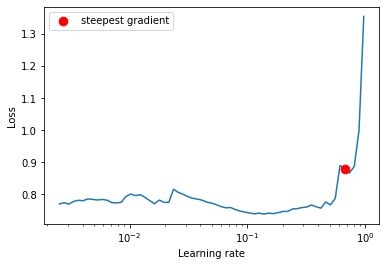

(574, 1)
(574, 1)
(144, 1)
(144, 1)


KeyboardInterrupt: ignored

In [ ]:
from torch_lr_finder import LRFinder


DEVICE = "cuda"
EPOCHS = 40
batch_size = 16
HEIGHT = 224
WIDTH = 224

def train(fold,save_model=False):
     
    df = pd.read_csv('drive/My Drive/TB_zindi/inputs/TB_stratified_kfold.csv')
    df_train = df[df.kfold!=fold].reset_index(drop=True)

    df_val = df[df.kfold==fold].reset_index(drop=True)

    x_train = df_train.loc[:,["ID"]]
    y_train = df_train.loc[:,["LABEL"]].values

    print(x_train.shape)
    print(y_train.shape)
    x_val = df_val.loc[:,["ID"]]
    y_val = df_val.loc[:,["LABEL"]].values
    
    print(x_val.shape)
    print(y_val.shape)

    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    
    train_aug =albumentations.Compose([  
            albumentations.CLAHE(p=0.75),                                                                                                       
            albumentations.Resize(224,224,always_apply=True),
            albumentations.Normalize(mean,std,max_pixel_value=255.0,always_apply=True),
            albumentations.CenterCrop(height=224,width=224),
            albumentations.Rotate(limit=30,p=0.75),
            #albumentations.HorizontalFlip(p=0.001),
            albumentations.Cutout(p=0.75)
        ])
    
    #Gaussian noise (p-val=0.038), gamma (p-val=0.003), brightness
    #(p-val=0.002), rotation (p-val=0.001), flip (p-val=0.001),
    #best set (p-val=0.001).
        
    val_aug = albumentations.Compose([
            albumentations.Resize(224,224,always_apply=True),
            albumentations.Normalize(mean,std,max_pixel_value=255.0,always_apply=True),
            albumentations.CenterCrop(224, 224)
        ])
    
    train_data= TB_Dataset_lr('drive/My Drive/TB_zindi/inputs/train_small',x_train, y_train,mean,std,transform=train_aug)
    #print(train_data[0])
    #print(train_data[1])
    train_data_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,
    shuffle=True,num_workers=2,pin_memory=True)

    #train_data_loader2 = torch.utils.data.DataLoader(train_data,batch_size=batch_size,
    #shuffle=True,num_workers=2,pin_memory=True)

    val_data= TB_Dataset_lr('drive/My Drive/TB_zindi/inputs/train_small',x_val, y_val,mean,std,transform=val_aug)
    val_data_loader = torch.utils.data.DataLoader(val_data,batch_size=32,
    shuffle=False,num_workers=2,pin_memory=True)
    

    model = resnet152(pretrained=True)           
    model.to(DEVICE)
    step_size = 2*(x_train.shape[0]//batch_size)
    optimizer = torch.optim.AdamW(model.parameters())
    
    criterion = nn.BCEWithLogitsLoss()
    #optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
    lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
    lr_finder.range_test(train_data_loader, end_lr=10, num_iter=100)
    lr_finder.plot() # to inspect the loss-learning rate graph
    lr_finder.reset()
    

        
        


for i in range(5):
    train(fold=i,save_model=True)
    

In [ ]:
predictions = []
img_ids = []
DEVICE = "cuda"
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
for i in range(5):

    model = resnet152(pretrained=False)
    model.load_state_dict(torch.load(f"drive/My Drive/TB_zindi/models/model{fold}.bin"))
    model= model.to(DEVICE)
    model.eval()
    test_ids = pd.read_csv('drive/My Drive/TB_zindi/inputs/Test_TB.csv')

    test_aug = albumentations.Compose([
               albumentations.Normalize(mean,std,max_pixel_value=255.0,always_apply=True),                                                                         
           ])
    
    test_data= TB_Test_Dataset('drive/My Drive/TB_zindi/inputs/test_small',test_ids,height=224,width=224,mean,std)

    test_data_loader = torch.utils.data.DataLoader(test_data,batch_size=16,
    shuffle=False,num_workers=8,pin_memory=True)
  
    with torch.no_grad():
      for idx,_data in enumerate(test_data_loader):
        img = _data['x']
        img_id = _data['img']
        img = img.to(DEVICE,dtype=torch.float)
        #print(image.shape)
        pred = model(img)
        pred = torch.softmax(pred,dim=1)
        pred = pred.detach().cpu().numpy()
        audio_ids.append(img_id)
        predictions.append(pred)
